In [1]:
%load_ext autoreload

In [2]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
BASE_PATH = os.path.join(os.getcwd(), "..", "..")
MODULES_PATH = os.path.join(BASE_PATH, "modules")
METRICS_PATH = os.path.join(BASE_PATH, "metrics")
STAT_PATH = os.path.join(BASE_PATH, "stats", "ios")

In [4]:
sys.path.append(MODULES_PATH)
sys.path.append(os.path.join(BASE_PATH, "tf_al"))

In [31]:
from tf_al import ExperimentSuitMetrics
from utils import MetricsTransformer, Frame, ExperimentFrame, FrameScores, Stats, Table, StatWriter

In [32]:
dtypes = {
    "run": int,
    "iteration": int,
    "train_time": float,
    "eval_sparse_categorical_crossentropy": float,
    "eval_sparse_categorical_accuracy": float,
    "query_time": float,
    "labeled_pool_size": int,
    "unlabeled_pool_size": int,
    "method": str
}

In [33]:
stat_writer = StatWriter(STAT_PATH)

# Mc Dropout

In [7]:
base_experiment_path = os.path.join(METRICS_PATH, "mnist_ios")
metrics_handler = ExperimentSuitMetrics(base_experiment_path)
df_mc = MetricsTransformer.load_from_dir(metrics_handler, "mc_dropout", dtype=dtypes)
scores = FrameScores(accuracy_column="eval_sparse_categorical_accuracy")
mc_frame = ExperimentFrame(df_mc, scores=scores)
df_mc = mc_frame.get_frame()

/home/exleonem/.anaconda/envs/active_learning/lib/python3.8/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


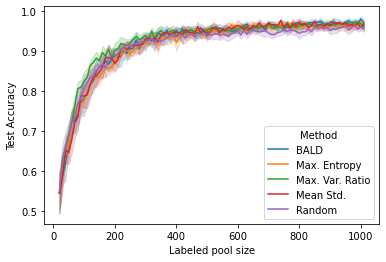

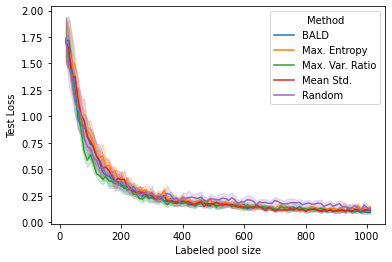

In [36]:
stat_writer.write(df_mc)

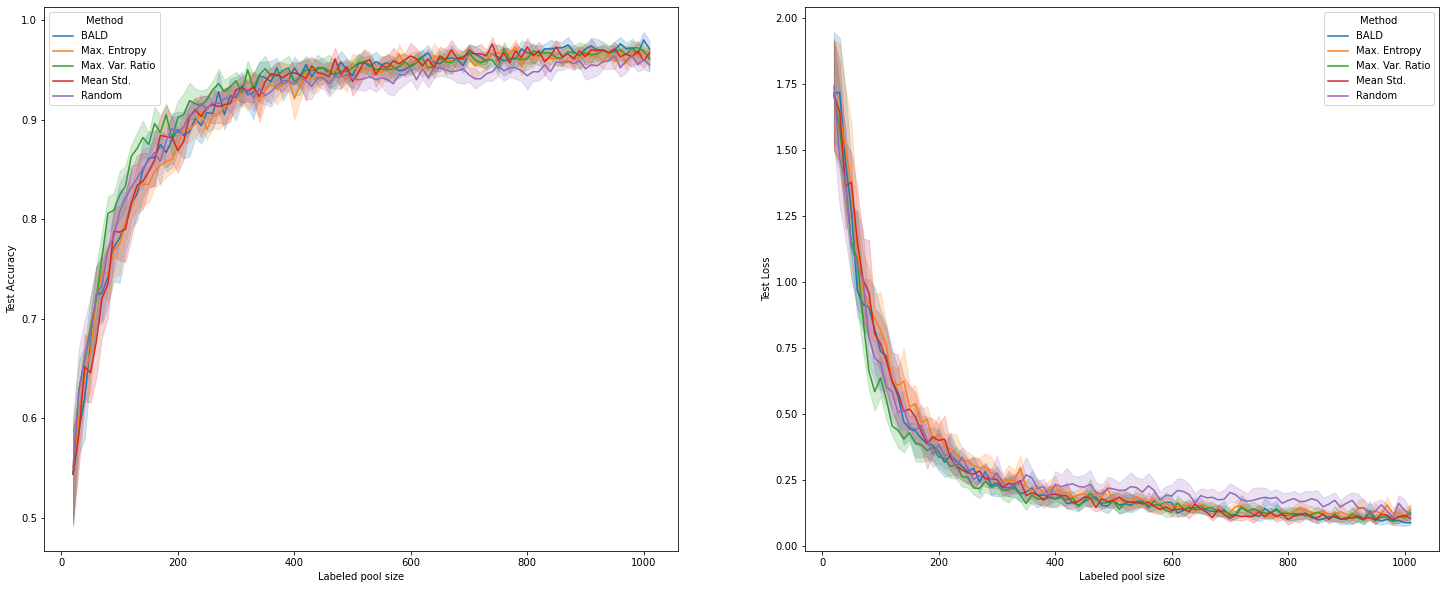

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(25, 10))
sns.lineplot(ax=ax[0], data=df_mc, x="labeled_pool_size", y="eval_sparse_categorical_accuracy", hue="method")
ax[0].legend(title="Method")
ax[0].set_xlabel("Labeled pool size")
ax[0].set_ylabel("Test Accuracy")

sns.lineplot(ax=ax[1], data=df_mc, x="labeled_pool_size", y="eval_sparse_categorical_crossentropy", hue="method")
ax[1].legend(title="Method")
ax[1].set_xlabel("Labeled pool size")
ax[1].set_ylabel("Test Loss")

plt.savefig(os.path.join(STAT_PATH, "mc_dropout_loss_acc.png"))

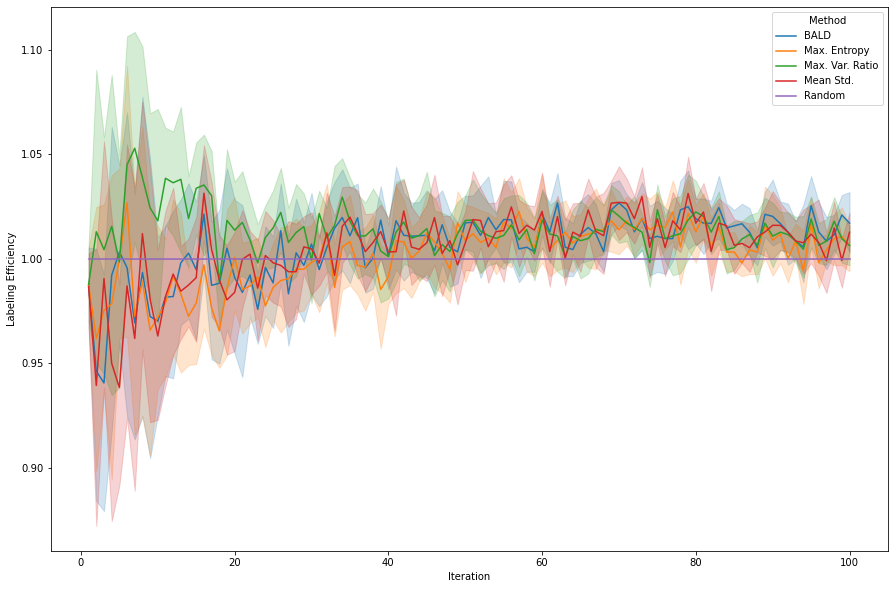

In [9]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.lineplot(ax=ax, data=df_mc, x="iteration", y="mean_leff", hue="method")
ax.legend(title="Method")
ax.set_xlabel("Iteration")
ax.set_ylabel("Labeling Efficiency")


#ax.set(xlabel="Iteration", ylabel="Query time in seconds per datapoint.")
plt.savefig(os.path.join(STAT_PATH, "mc_dropout_leff.png"))

(0.27, 0.3)

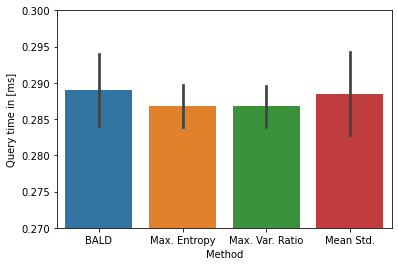

In [10]:
selector = df_mc["method"] != "Random"
tmp = df_mc.copy()
tmp["query_time"] = tmp["query_time"] * 1000
ax = sns.barplot(data=tmp[selector], x="method", y="query_time", ci="sd")
ax.set(xlabel="Method", ylabel="Query time in [ms]")
ax.set_ylim(0.27, 0.3)

# Moment Propagation

In [11]:
df_mp = MetricsTransformer.load_from_dir(metrics_handler, "moment_propagation", dtype=dtypes)
scores = FrameScores(accuracy_column="eval_sparse_categorical_accuracy")
mp_frame = ExperimentFrame(df_mp, scores=scores)
df_mp = mp_frame.get_frame()

/home/exleonem/.anaconda/envs/active_learning/lib/python3.8/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


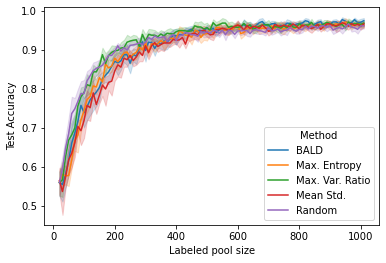

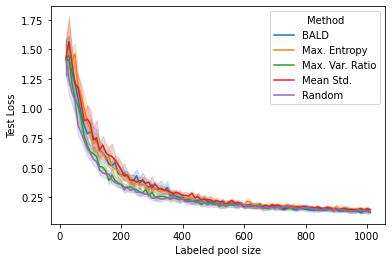

In [37]:
stat_writer.write(df_mp)

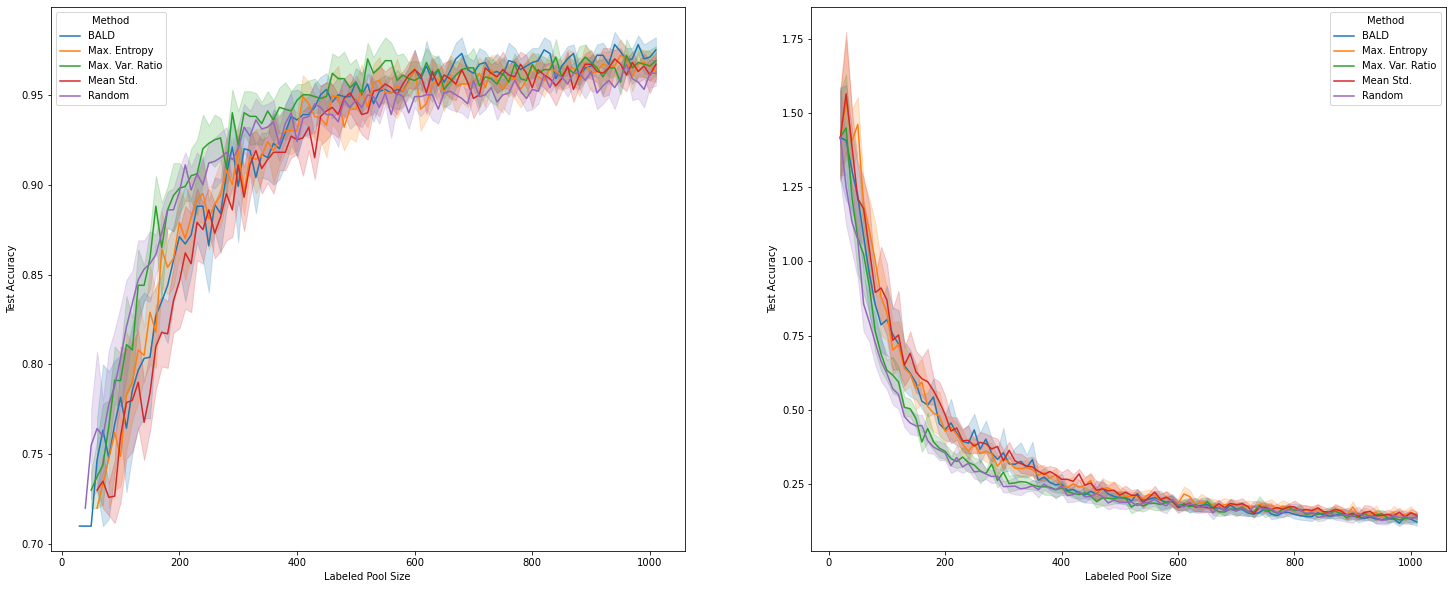

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(25, 10))
selector = df_mp["eval_sparse_categorical_accuracy"] > .7
sns.lineplot(ax=ax[0], data=df_mp[selector], x="labeled_pool_size", y="eval_sparse_categorical_accuracy", hue="method")
ax[0].set_xlabel("Labeled Pool Size")
ax[0].set_ylabel("Test Accuracy")
ax[0].legend(title="Method")

sns.lineplot(ax=ax[1], data=df_mp, x="labeled_pool_size", y="eval_sparse_categorical_crossentropy", hue="method")
ax[1].set_xlabel("Labeled Pool Size")
ax[1].set_ylabel("Test Accuracy")
ax[1].legend(title="Method")

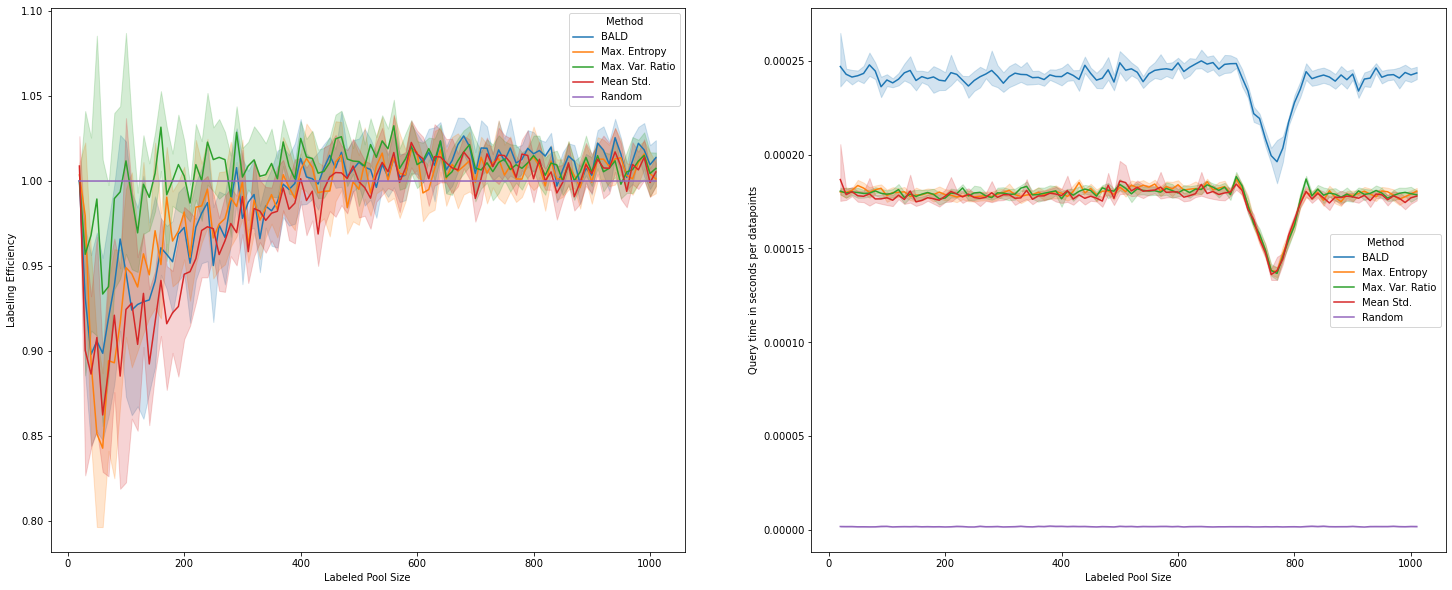

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(25, 10))
sns.lineplot(ax=ax[0], data=df_mp, x="labeled_pool_size", y="mean_leff", hue="method")
ax[0].set_xlabel("Labeled Pool Size")
ax[0].set_ylabel("Labeling Efficiency")
ax[0].legend(title="Method")

sns.lineplot(ax=ax[1], data=df_mp, x="labeled_pool_size", y="query_time", hue="method")
ax[1].set_xlabel("Labeled Pool Size")
ax[1].set_ylabel("Query time in seconds per datapoints")
ax[1].legend(title="Method")

In [14]:
num_of_datapoints = np.array([10_000, 20_000, 40_000, 80_000, 160_000])
qt_dp_mp = Stats.query_time_per_datapoints(df_mp, num_of_datapoints)
qt_dp_mc = Stats.query_time_per_datapoints(df_mc, num_of_datapoints)

In [15]:
qt_dp_mc.insert(0, "model", "Mc Dropout")
qt_dp_mp.insert(0, "model", "Moment Propagation")

In [16]:
merged_times = pd.concat([qt_dp_mc, qt_dp_mp])
merged_times = merged_times.rename(columns={"model": "Model", "method": "Method"})

[Text(0.5, 0, 'Num of datapoints to query'),
 Text(0, 0.5, 'Query time in seconds')]

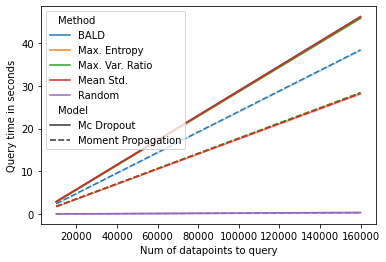

In [17]:
fig = sns.lineplot(data=merged_times, x="size", y="times", hue="Method", style="Model")
fig.set(xlabel="Num of datapoints to query", ylabel="Query time in seconds")

Text(0.5, 1.0, 'Runtime of query functions per datapoint')

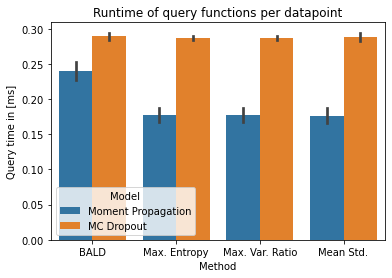

In [18]:
composite_df = pd.concat([df_mp, df_mc])
composite_df["query_time"] = composite_df["query_time"]*1000

selector = composite_df["method"] != "Random"
fig = sns.barplot(data=composite_df[selector], x="method", y="query_time", hue="model", ci="sd")
fig.set(xlabel="Method", ylabel="Query time in [ms]")
fig.legend(title="Model")
fig.set_title("Runtime of query functions per datapoint")

In [19]:
df_mp_mean = mp_frame.get_mean_frame()
df_mc_mean = mc_frame.get_mean_frame()

df_mc_mean["query_time"] = df_mc_mean["query_time"]-df_mp_mean["query_time"]
df_mc_mean["query_time"] = df_mc_mean["query_time"]*1000

Text(0.5, 1.0, 'Performance increase Moment Propagation compared to Mc Dropout')

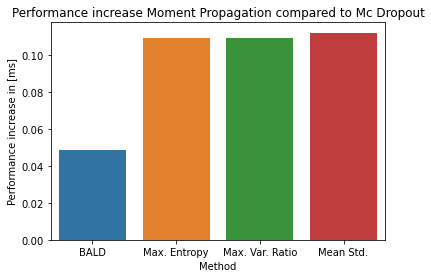

In [20]:
selector = df_mc_mean["method"] != "Random"
fig = sns.barplot(data=df_mc_mean[selector], x="method", y="query_time", ci=None)
fig.set(xlabel="Method", ylabel="Performance increase in [ms]")
fig.set_title("Performance increase Moment Propagation compared to Mc Dropout")

In [21]:
df_merged = pd.concat([df_mc, df_mp])

In [ ]:
stat_writer.write_compare(df_merged)

Text(0.5, 1.0, 'Acquisition function: Max. Var. Ratio')

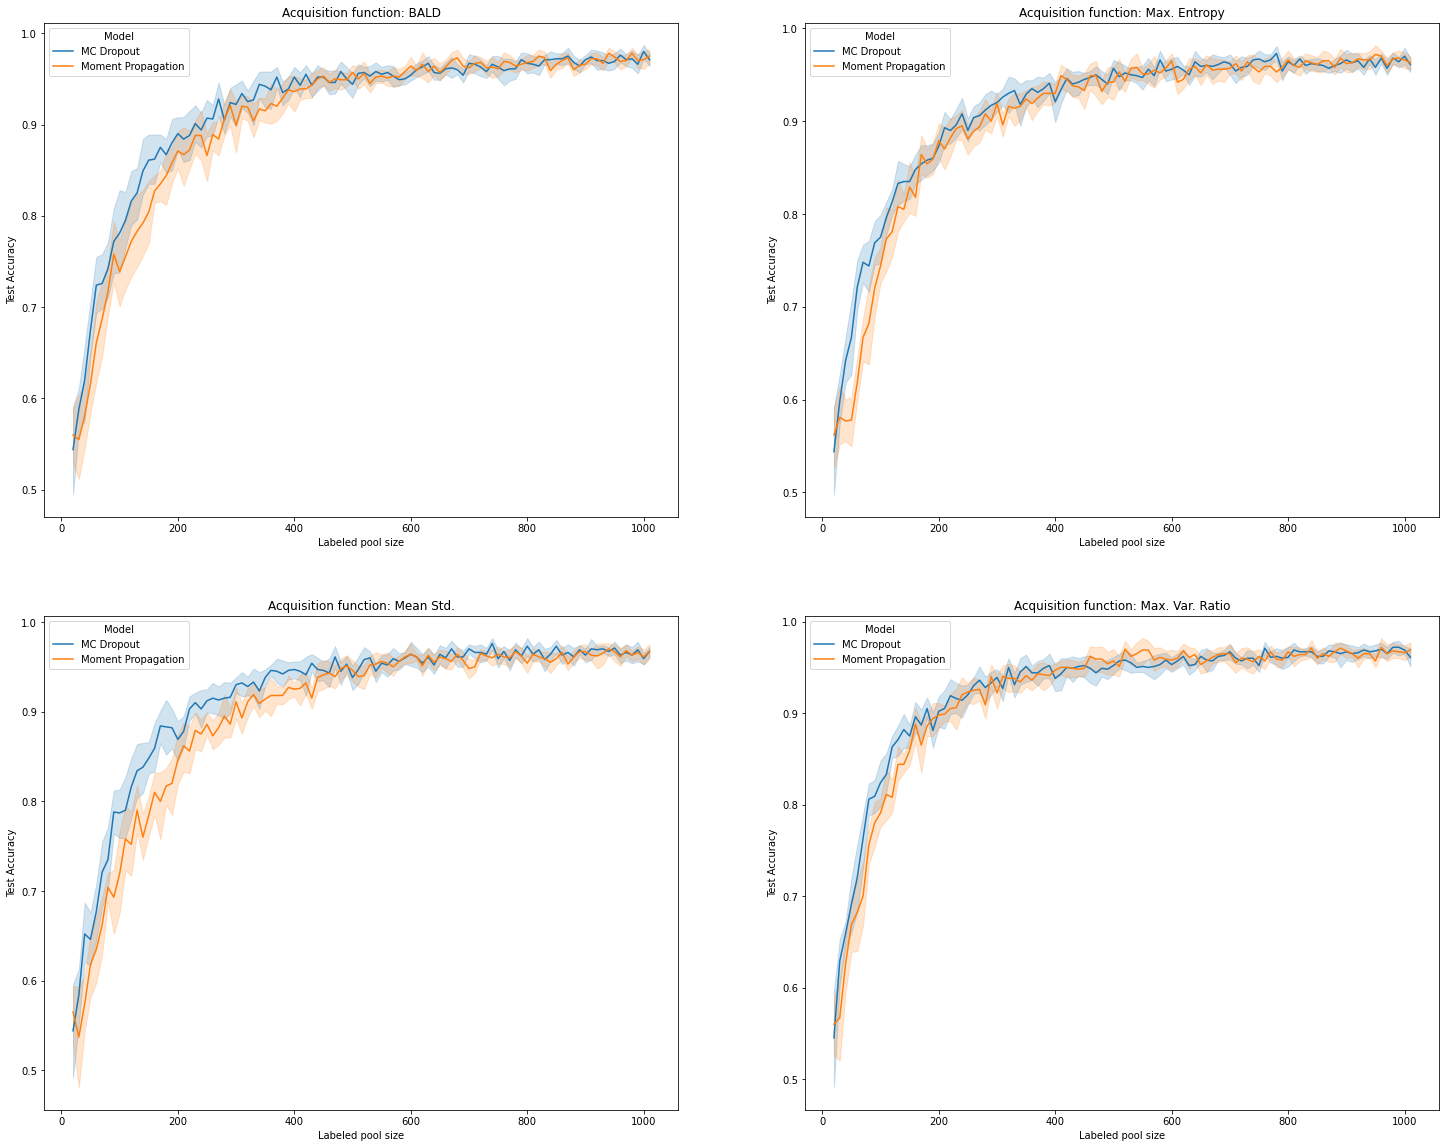

In [22]:
fig, ax = plt.subplots(2, 2, figsize=(25, 20))

selector = df_merged["method"] == "BALD"
sns.lineplot(ax=ax[0][0], data=df_merged[selector], x="labeled_pool_size", y="eval_sparse_categorical_accuracy", hue="model")
ax[0][0].set_xlabel("Labeled pool size")
ax[0][0].set_ylabel("Test Accuracy")
ax[0][0].legend(title="Model")
ax[0][0].set_title("Acquisition function: BALD")

selector = df_merged["method"] == "Max. Entropy"
fig = sns.lineplot(ax=ax[0][1], data=df_merged[selector], x="labeled_pool_size", y="eval_sparse_categorical_accuracy", hue="model")
ax[0][1].set_xlabel("Labeled pool size")
ax[0][1].set_ylabel("Test Accuracy")
ax[0][1].legend(title="Model")
ax[0][1].set_title("Acquisition function: Max. Entropy")

selector = df_merged["method"] == "Mean Std."
fig = sns.lineplot(ax=ax[1][0], data=df_merged[selector], x="labeled_pool_size", y="eval_sparse_categorical_accuracy", hue="model")
ax[1][0].set_xlabel("Labeled pool size")
ax[1][0].set_ylabel("Test Accuracy")
ax[1][0].legend(title="Model")
ax[1][0].set_title("Acquisition function: Mean Std.")

selector = df_merged["method"] == "Max. Var. Ratio"
fig = sns.lineplot(ax=ax[1][1], data=df_merged[selector], x="labeled_pool_size", y="eval_sparse_categorical_accuracy", hue="model")
ax[1][1].set_xlabel("Labeled pool size")
ax[1][1].set_ylabel("Test Accuracy")
ax[1][1].legend(title="Model")
ax[1][1].set_title("Acquisition function: Max. Var. Ratio")

# Variance in initial training 

[Text(0.5, 0, 'Method'), Text(0, 0.5, 'Test Accuracy')]

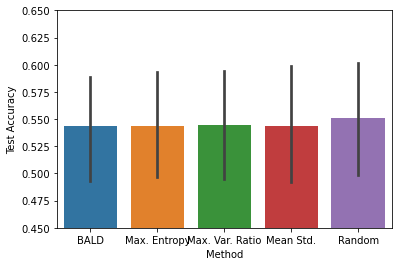

In [23]:
selector = df_mc["iteration"] == 1
fig = sns.barplot(data=df_mc[selector], x="method", y="eval_sparse_categorical_accuracy")
fig.set_ylim(0.45, 0.65)
fig.set(xlabel="Method", ylabel="Test Accuracy")

(0.5, 0.6)

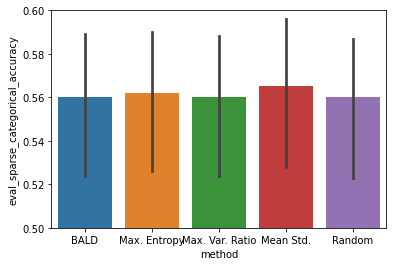

In [24]:
selector = df_mp["iteration"] == 1
fig = sns.barplot(data=df_mp[selector], x="method", y="eval_sparse_categorical_accuracy")
fig.set_ylim(0.5, 0.6)

# Runtime boxplot

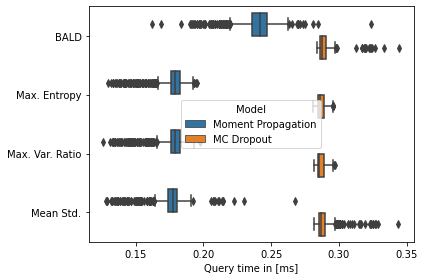

In [25]:
composite_df = pd.concat([df_mp, df_mc])
#composite_df = composite_df.groupby(["model", "method", "run"]).mean()
composite_df["query_time"] = composite_df["query_time"]*1000
selector = composite_df["method"] != "Random"

#plt.figure(dpi=300)

fig = sns.boxplot(data=composite_df[selector], y="method", x="query_time", hue="model")
fig.set(xlabel="Query time in [ms]", ylabel="")
fig.legend(title="Model")

#plt.grid()
plt.tight_layout()
plt.savefig(os.path.join(STAT_PATH, "mp_mc_runtime_boxplot.png"))

# AUC/Query Time Table

In [26]:

table_query_time = Table.query_time(pd.concat([df_mc, df_mp]), decimals=6)
table_query_time = Frame.merge_mean_std(table_query_time)
table_query_time.columns = ["Query Time"]
table_query_time

Query Time
Method          Model                                 
BALD            MC Dropout            0.000289 ± 5e-06
                Moment Propagation   0.00024 ± 1.2e-05
Max. Entropy    MC Dropout            0.000287 ± 3e-06
                Moment Propagation    0.000178 ± 1e-05
Max. Var. Ratio MC Dropout            0.000287 ± 3e-06
                Moment Propagation    0.000178 ± 1e-05
Mean Std.       MC Dropout            0.000289 ± 6e-06
                Moment Propagation  0.000176 ± 1.1e-05
Random          MC Dropout                 2e-06 ± 0.0
                Moment Propagation         2e-06 ± 0.0

In [27]:
auc_mean_std = Table.auc(pd.concat([df_mc, df_mp]), decimals=3)
auc_mean_std = Frame.merge_mean_std(auc_mean_std)
auc_mean_std.columns = ["AUC"]
auc_mean_std

AUC
Method          Model                            
BALD            MC Dropout          0.901 ± 0.011
                Moment Propagation  0.891 ± 0.009
Max. Entropy    MC Dropout          0.897 ± 0.006
                Moment Propagation  0.888 ± 0.008
Max. Var. Ratio MC Dropout          0.908 ± 0.006
                Moment Propagation  0.903 ± 0.009
Mean Std.       MC Dropout            0.9 ± 0.011
                Moment Propagation  0.883 ± 0.009
Random          MC Dropout          0.896 ± 0.008
                Moment Propagation  0.897 ± 0.008

In [28]:
qt_auc = pd.concat([auc_mean_std, table_query_time], axis=1)
qt_auc.to_latex(os.path.join(STAT_PATH, "tables", "auc_qt_mp_mc.tex"))
qt_auc

FileNotFoundError: [Errno 2] No such file or directory: '/home/exleonem/Desktop/workspace/thesis/wp/notebooks/experiments/../../stats/ios/tables/auc_qt_mp_mc.tex'